In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Exercise 3

### Question A

In [24]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [25]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


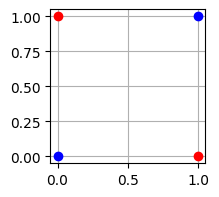

In [26]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()

plt.show()

In [27]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, one_hot=False):
        # Initialize number of nodes of input, hidden, and output layer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Use of one_hot encoding
        self.one_hot = one_hot

        # Initialize weights (w) and biases (b)
        # input -> hidden
        self.w1 = np.random.rand(self.input_size, self.hidden_size) # 35*10
        self.b1 = np.zeros((1, self.hidden_size)) # 1*10

        # hidden -> output
        self.w2 = np.random.rand(self.hidden_size, self.output_size) # 10*1
        self.b2 = np.zeros((1, self.output_size)) # 1*1

    def sigmoid(self, x, deriv=False):
        """Sigmoid activation function"""
        if deriv:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def reLU(self, x):
        """reLU activation function"""
        return np.maximum(0, x)

    def one_hot_encoding(self, y):
        """Encode digit to one-hot (used in error calculation of backpropagation)"""
        y = y.reshape(-1, 10)
        encoded_y = np.zeros((y.size, y.max() + 1))
        encoded_y[np.arange(y.size), y.flatten()] = 1
        encoded_y = encoded_y.T
        return encoded_y

    def feedforward(self, x):
        """Feedforward"""
        # input -> hidden
        self.z1 = np.dot(x, self.w1) + self.b1 # 10*35 @ 35*10 = 10*10
        self.a1 = self.sigmoid(self.z1)

        # hidden -> output
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # 10*10 @ 10*1 = 10*1
        self.a2 = self.sigmoid(self.z2) # 10*1

        return self.a2

    def backpropagation(self, x, y, learning_rate):
        """Backpropagation"""        
        self.m = y.size
        
        self.d_z2 = self.a2 - y # 10*1
        self.d_w2 = np.dot(self.a1.T, self.d_z2) / self.m # 10*10 @ 10*1 = 10*1
        self.d_b2 = np.sum(self.d_z2) / self.m # 1*1
        
        self.d_z1 = np.dot(self.d_z2, self.w2.T) * self.sigmoid(self.z1, deriv=True) # 10*1 @ 1*10
        self.d_w1 = np.dot(x.T, self.d_z1) / self.m
        self.d_b1 = np.sum(self.d_z1) / self.m

        self.w1 -= self.d_w1 * learning_rate
        self.b1 -= self.d_b1 * learning_rate
        self.w2 -= self.d_w2 * learning_rate
        self.b2 -= self.d_b2 * learning_rate

    def train(self, x, y, learning_rate, epochs):
        """Optimize weight and bias parameters""" 
        if self.one_hot:
            y = self.one_hot_encoding(y)
        
        for epoch in range(epochs):
            self.feedforward(x)
            self.backpropagation(x, y, learning_rate)

            if not epoch % (epochs / 10):
                loss = np.mean(np.square(y - self.a2))
                print(f'Epoch {epoch}: {loss}')

    def predict(self, x):
        """Get feedforward result with current parameters"""
        return self.feedforward(x)

In [29]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork(2, 2, 1)
nn_A.train(x, y, learning_rate, epochs)
nn_A.predict(x)

Epoch 0: 0.28239561546814484
Epoch 1000: 0.2367521529520285
Epoch 2000: 0.18492295934126235
Epoch 3000: 0.08550570841104331
Epoch 4000: 0.017027514032010138
Epoch 5000: 0.004875636550109115
Epoch 6000: 0.0020711364099320847
Epoch 7000: 0.0011001579403774136
Epoch 8000: 0.0006692113923838893
Epoch 9000: 0.00044517456880481163


array([[0.01899978],
       [0.9837789 ],
       [0.98377873],
       [0.01934879]])

### Question B

Load raw data

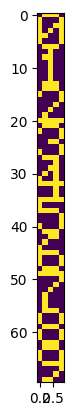

In [30]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [31]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

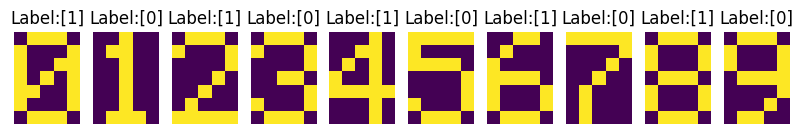

In [32]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [35]:
input_size = 35
hidden_size = 10
output_size = 1

learning_rate = 0.1
epochs = 10000

nn_B = NeuralNetwork(input_size, hidden_size, output_size)
nn_B.train(x, y, learning_rate, epochs)
nn_B.predict(x)

Epoch 0: 0.49218539655063936
Epoch 1000: 0.24912310785387876
Epoch 2000: 0.031089356960779403
Epoch 3000: 0.0015017062511186435
Epoch 4000: 0.00042883227664536355
Epoch 5000: 0.00019660548259597537
Epoch 6000: 0.00011175288241647504
Epoch 7000: 7.179705332612812e-05
Epoch 8000: 4.9919118240704236e-05
Epoch 9000: 3.667607132900665e-05


array([[0.99481976],
       [0.00491146],
       [0.99452727],
       [0.00703957],
       [0.99596   ],
       [0.00462815],
       [0.99570532],
       [0.00471326],
       [0.99353848],
       [0.00548034]])

digit is even: [[0.99570532]]


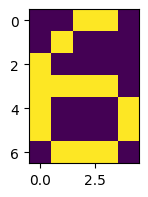

In [37]:
digit = 6

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

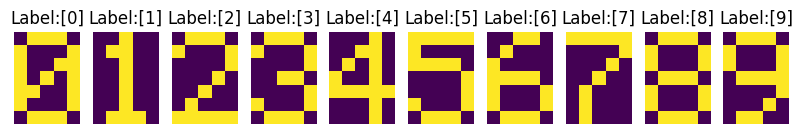

In [38]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [20]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 100000

nn_C = NeuralNetwork(input_size, hidden_size, output_size, one_hot=True)
nn_C.train(x, y, learning_rate, epochs)
nn_C.predict(x)

Epoch 0: 0.8800771248922876
Epoch 10000: 0.08997352049619786
Epoch 20000: 0.08225647442907148
Epoch 30000: 0.06849769244550814
Epoch 40000: 0.042619982674858996
Epoch 50000: 0.012119387635258853
Epoch 60000: 0.0036597884068427645
Epoch 70000: 0.0015265744634709922
Epoch 80000: 0.0008263133977554393
Epoch 90000: 0.0005169543946543574


array([[9.26328405e-01, 2.27966587e-05, 3.33021455e-05, 2.31295854e-03,
        1.50610313e-02, 7.70791206e-03, 5.83848544e-03, 2.16727280e-04,
        1.55675176e-02, 1.02555619e-04],
       [1.30223611e-03, 9.70657145e-01, 2.77728236e-03, 6.32215942e-03,
        1.09181855e-03, 1.80872385e-03, 6.45014632e-03, 4.96772946e-03,
        4.22828310e-07, 2.16277222e-06],
       [6.37596759e-04, 4.74255534e-04, 9.76963978e-01, 1.42770971e-02,
        7.17360385e-04, 1.85425890e-06, 4.99801722e-06, 3.71524418e-03,
        3.21481360e-03, 2.64931280e-03],
       [7.75895956e-03, 1.75693962e-04, 1.14505013e-02, 9.39446936e-01,
        7.43883532e-05, 1.00600140e-06, 2.32186049e-04, 4.74170414e-03,
        3.21502294e-02, 2.64907575e-04],
       [1.63731706e-02, 2.54891329e-04, 3.43230773e-04, 6.12298489e-05,
        9.76796495e-01, 4.87422483e-03, 9.67685915e-04, 8.01832011e-05,
        1.35022045e-03, 2.18961416e-04],
       [7.38575455e-03, 1.59956201e-02, 9.88703739e-06, 1.65460982e-06,
   

[[7.38575455e-03 1.59956201e-02 9.88703739e-06 1.65460982e-06
  2.59708052e-03 9.47937953e-01 1.27229704e-02 1.05371609e-02
  3.23334693e-06 1.15340205e-02]]
digit is: 5


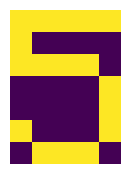

In [252]:
digit = 5

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print(res)
print('digit is:', np.argmax(res))

In [224]:
def salt_pepper_noise(img, salt_probability, pepper_probability):
    img_copy = np.copy(img)
    salt = np.random.rand(img.size) < salt_probability
    pepper = np.random.rand(img.size) < pepper_probability
    img_copy[salt] = 1
    img_copy[pepper] = 0
    return img_copy

def random_noise(img):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.rand(img_copy.size)
    return img_copy

def gaussian_noise(img, mean, std):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.normal(mean, std, img_copy.size)
    return img_copy

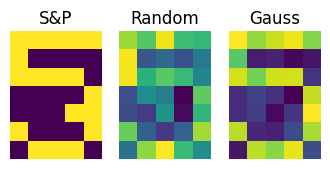

In [307]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit])
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [308]:
np.argmax(nn_C.predict(random_digit))

5